In [1]:
import pandas as pd
import numpy as np


# for Modelling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense

from tensorflow.keras.models import load_model

# for Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

# Import required library
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
df= pd.read_csv('ax_t1.csv')
df

,Time id,Material,Quantity,Total_Value,Material_Id
0,1,C37-200258,35.0,392625.71,1708
1,1,C65-200280,45.0,108333.72,2425
2,1,S02-060397,6.0,94652.74,6324
3,1,S06-310007,82.0,88564.92,6587
4,1,S10-130653,32.0,414240.00,7385
...,...,...,...,...,...
373,38,S06-310007,198.0,175678.84,6587
374,38,S10-130653,97.0,740962.30,7385
375,38,S10-130781,132.0,546171.00,7413
376,38,S12-060214,25.0,416336.42,14426


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to build and train RNN models
def build_and_train_model(model_type, X_train, y_train):
    model = Sequential()
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    return model

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize an empty DataFrame to store the forecast results
forecast_df = pd.DataFrame(columns=['Time id', 'Material id', 'Model', 'Actual Quantity', 'Forecasted', 'MAE', 'MAPE', 'R2'])

# Iterate over each material id
for material_id in df['Material_Id'].unique():
    print(f"Forecasting for Material ID: {material_id}")

    # Filter data for the current material id
    material_data = df[df['Material_Id'] == material_id]

    # Split data into train and test sets
    train = material_data[(material_data['Time id'] >= 13) & (material_data['Time id'] <= 27)]
    test = material_data[material_data['Time id'] == 28]

    # Check if both train and test sets have at least one sample
    if len(train) == 0 or len(test) == 0:
        print(f"Skipping Material ID: {material_id} due to empty train or test set.")
        continue

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train[['Quantity']])
    test_scaled = scaler.transform(test[['Quantity']])

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(train_scaled, (train_scaled.shape[0], 1, 1))
    X_test = np.reshape(test_scaled, (test_scaled.shape[0], 1, 1))
    y_train = train_scaled[:, 0]  # Target variable is Quantity

    # Iterate over each model type
    for model_type in ['SimpleRNN', 'GRU', 'LSTM']:
        print(f"Forecasting with {model_type} model for Material ID: {material_id}")

        # Build and train model
        model = build_and_train_model(model_type, X_train, y_train)

        # Forecast for the test set
        forecasted_values = model.predict(X_test)
        forecasted_values_inv = scaler.inverse_transform(forecasted_values)

        # Get actual quantity for the test set
        actual_quantity = test['Quantity'].values[0]

        # Calculate MAE and MAPE
        mae = mean_absolute_error([actual_quantity], forecasted_values_inv[0])
        mape = mean_absolute_percentage_error([actual_quantity], forecasted_values_inv[0])

        # Calculate R²
        mse = mean_squared_error([actual_quantity], forecasted_values_inv[0])
        r2 = 1 - (mse / (actual_quantity ** 2))  # Simplified R² calculation

        # Append results to the dataframe
        forecast_df = forecast_df.append({
            'Time id': 28,
            'Material id': material_id,
            'Model': model_type,
            'Actual Quantity': actual_quantity,
            'Forecasted': forecasted_values_inv[0][0],
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        }, ignore_index=True)

# Display the forecast results dataframe
print(forecast_df)


Forecasting for Material ID: 1708
Forecasting with SimpleRNN model for Material ID: 1708


C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Forecasting with GRU model for Material ID: 1708


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Forecasting with LSTM model for Material ID: 1708


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Forecasting for Material ID: 2425
Forecasting with SimpleRNN model for Material ID: 2425


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Forecasting with GRU model for Material ID: 2425


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Forecasting with LSTM model for Material ID: 2425


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Forecasting for Material ID: 6324
Forecasting with SimpleRNN model for Material ID: 6324


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Forecasting with GRU model for Material ID: 6324


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Forecasting with LSTM model for Material ID: 6324


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Forecasting for Material ID: 6587
Forecasting with SimpleRNN model for Material ID: 6587


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Forecasting with GRU model for Material ID: 6587


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Forecasting with LSTM model for Material ID: 6587


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Forecasting for Material ID: 7385
Forecasting with SimpleRNN model for Material ID: 7385


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Forecasting with GRU model for Material ID: 7385


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Forecasting with LSTM model for Material ID: 7385


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Forecasting for Material ID: 7413
Forecasting with SimpleRNN model for Material ID: 7413


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Forecasting with GRU model for Material ID: 7413


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Forecasting with LSTM model for Material ID: 7413


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Forecasting for Material ID: 11101
Forecasting with SimpleRNN model for Material ID: 11101


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Forecasting with GRU model for Material ID: 11101


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Forecasting with LSTM model for Material ID: 11101


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Forecasting for Material ID: 14426
Forecasting with SimpleRNN model for Material ID: 14426


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Forecasting with GRU model for Material ID: 14426


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Forecasting with LSTM model for Material ID: 14426


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Forecasting for Material ID: 15905
Forecasting with SimpleRNN model for Material ID: 15905


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Forecasting with GRU model for Material ID: 15905


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Forecasting with LSTM model for Material ID: 15905


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Forecasting for Material ID: 18176
Forecasting with SimpleRNN model for Material ID: 18176


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecasting with GRU model for Material ID: 18176


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Forecasting with LSTM model for Material ID: 18176


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Forecasting for Material ID: 18997
Forecasting with SimpleRNN model for Material ID: 18997


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Forecasting with GRU model for Material ID: 18997


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Forecasting with LSTM model for Material ID: 18997


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Forecasting for Material ID: 22297
Forecasting with SimpleRNN model for Material ID: 22297


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Forecasting with GRU model for Material ID: 22297


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Forecasting with LSTM model for Material ID: 22297


C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
   Time id Material id      Model  Actual Quantity  Forecasted       MAE  \
0       28        1708  SimpleRNN              9.0   12.540668  3.540668   
1       28        1708        GRU              9.0   13.382534  4.382534   
2       28        1708       LSTM              9.0   15.407080  6.407080   
3       28        2425  SimpleRNN             37.0   40.868614  3.868614   
4       28        2425        GRU             37.0   43.702412  6.702412   
5       28        2425       LSTM             37.0   45.753120  8.753120   
6       28        6324  SimpleRNN             10.0    9.661270  0.338730   
7       28        6324        GRU             10.0    9.143374  0.856626   
8       28        6324       LSTM             10.0    8.965895  1.034105   
9       28        6587  SimpleRNN            105.0  105.199966  0.199966   
10      28        6587        GRU            105.0  105.946213  0.946213   
11      28        6587       LSTM            105.0

C:\Users\sohan\AppData\Local\Temp\ipykernel_1912\2619939675.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({


In [4]:
# Group forecast results by model
grouped_results = forecast_df.groupby('Model')

# Calculate overall MAE, MAPE, and R2 scores for each model
for model_type, group in grouped_results:
    overall_mae = group['MAE'].mean()
    overall_mape = group['MAPE'].mean()
    overall_r2 = group['R2'].mean()
    
    # Print the overall scores for the current model
    print(f"Overall scores for {model_type} model:")
    print("Overall MAE:", overall_mae)
    print("Overall MAPE:", overall_mape)
    print("Overall R2:", overall_r2)
    print()

Overall scores for GRU model:
Overall MAE: 2.9847848812739053
Overall MAPE: 45.104663035573196
Overall R2: -0.03734628897043784

Overall scores for LSTM model:
Overall MAE: 3.9580764373143515
Overall MAPE: 55.738712452908594
Overall R2: -0.4209094453029327

Overall scores for SimpleRNN model:
Overall MAE: 1.5791729092597961
Overall MAPE: 24.147642346872075
Overall R2: 0.6548504399893238



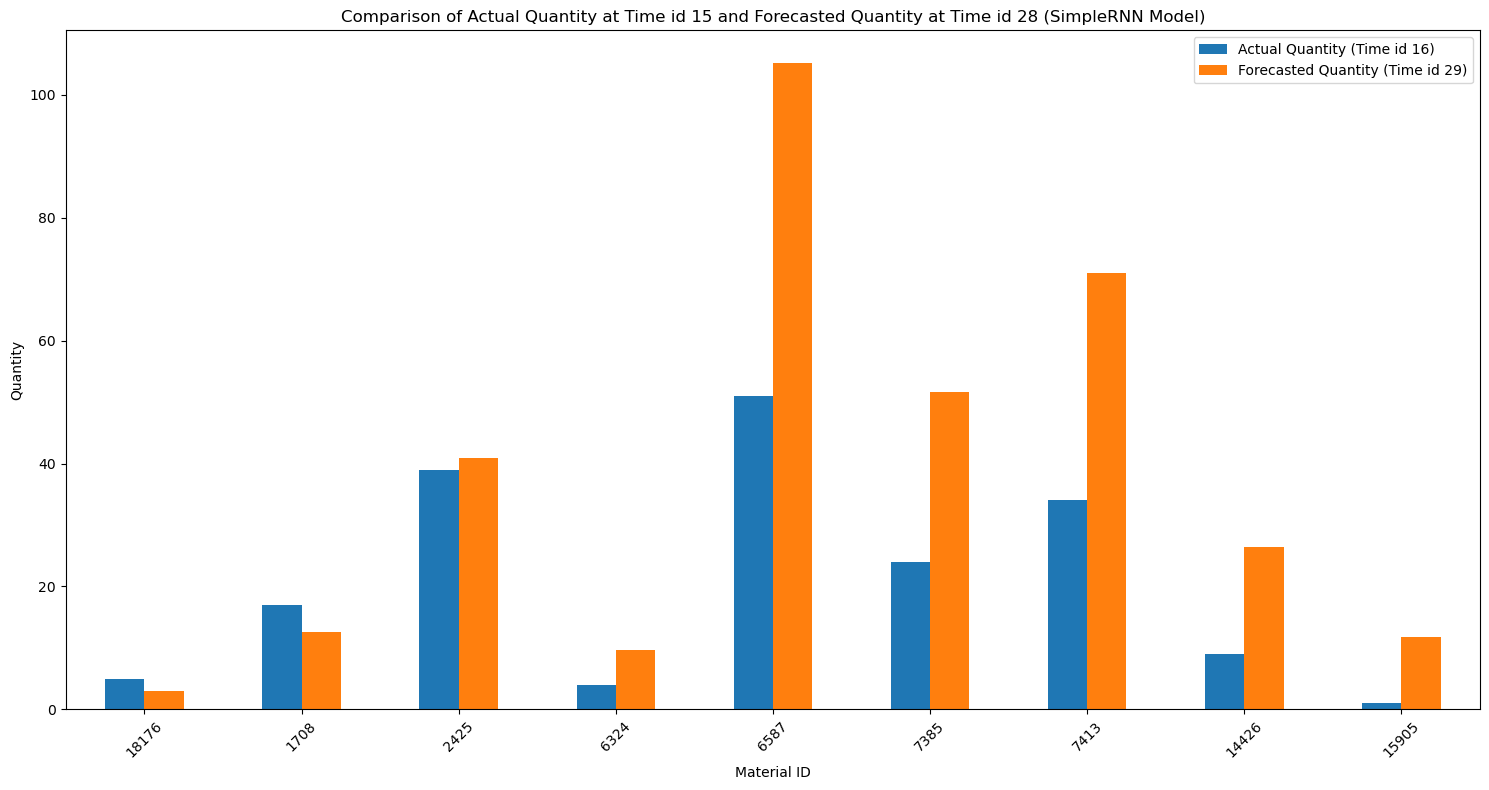

In [5]:
import matplotlib.pyplot as plt

# Filter df for Time id 28
actual_quantities = df[df['Time id'] == 16][['Material_Id', 'Quantity']]
actual_quantities = actual_quantities.set_index('Material_Id')

# Filter forecast_df for Time id 28 and SimpleRNN model
forecasted_quantities = forecast_df[(forecast_df['Time id'] == 28) & (forecast_df['Model'] == 'SimpleRNN')][['Material id', 'Forecasted']]
forecasted_quantities = forecasted_quantities.rename(columns={'Material id': 'Material_Id'})
forecasted_quantities = forecasted_quantities.set_index('Material_Id')

# Merge actual and forecasted quantities
merged_df = actual_quantities.join(forecasted_quantities, how='inner', lsuffix='_actual', rsuffix='_forecasted')

# Plotting
merged_df.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Material ID')
plt.ylabel('Quantity')
plt.title('Comparison of Actual Quantity at Time id 15 and Forecasted Quantity at Time id 28 (SimpleRNN Model)')
plt.xticks(rotation=45)
plt.legend(['Actual Quantity (Time id 16)', 'Forecasted Quantity (Time id 29)'])
plt.tight_layout()
plt.show()

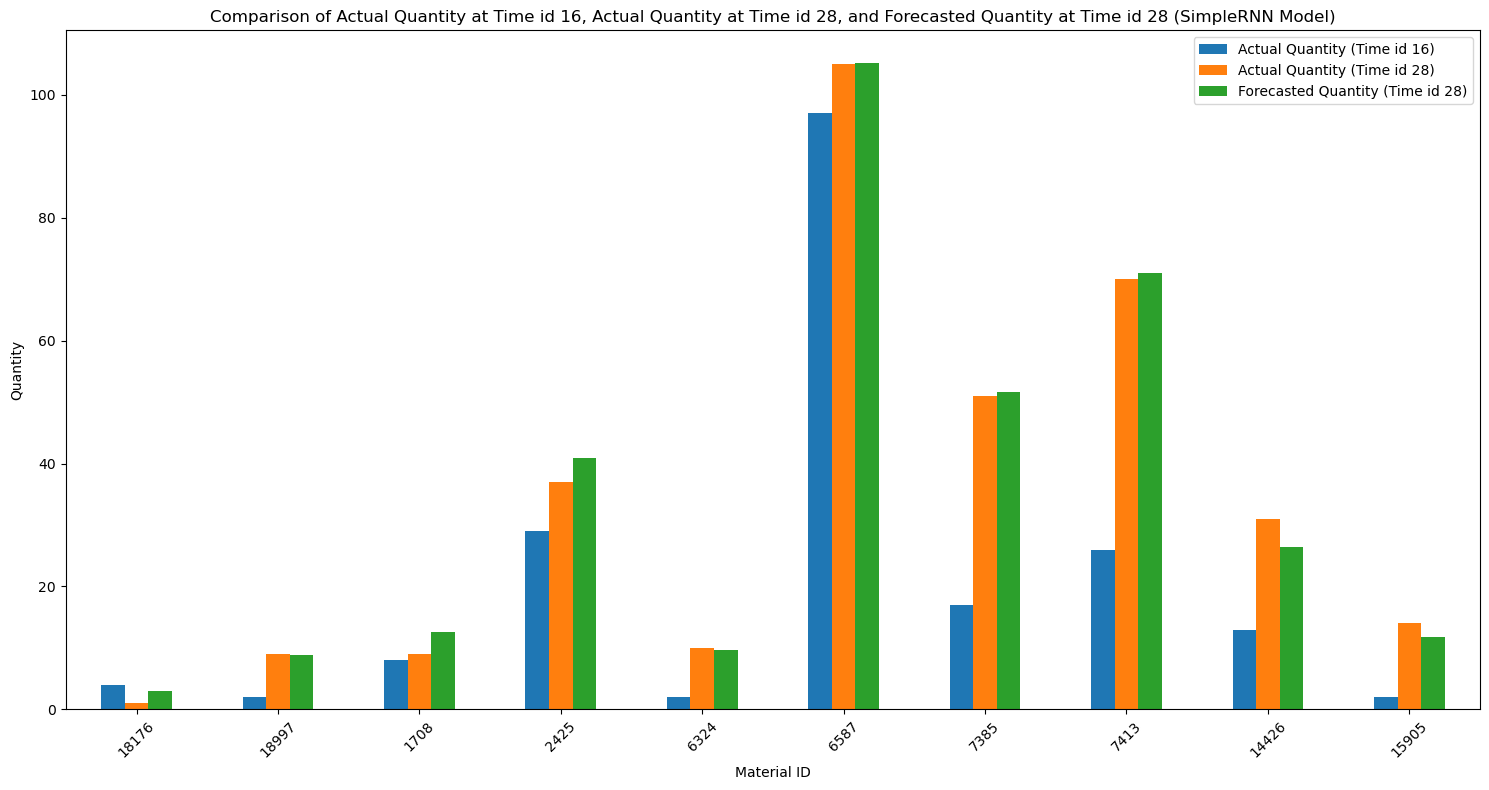

In [8]:
import matplotlib.pyplot as plt

# Filter df for Time id 16
actual_quantities_16 = df[df['Time id'] == 15][['Material_Id', 'Quantity']]
actual_quantities_16 = actual_quantities_16.set_index('Material_Id')

# Filter df for Time id 28
actual_quantities_28 = df[df['Time id'] == 28][['Material_Id', 'Quantity']]
actual_quantities_28 = actual_quantities_28.set_index('Material_Id')

# Filter forecast_df for Time id 28 and SimpleRNN model
forecasted_quantities = forecast_df[(forecast_df['Time id'] == 28) & (forecast_df['Model'] == 'SimpleRNN')][['Material id', 'Forecasted']]
forecasted_quantities = forecasted_quantities.rename(columns={'Material id': 'Material_Id'})
forecasted_quantities = forecasted_quantities.set_index('Material_Id')

# Merge actual quantities at Time id 16, Time id 28, and forecasted quantities
merged_df = actual_quantities_16.join(actual_quantities_28, how='inner', lsuffix='_actual_16', rsuffix='_actual_28')
merged_df = merged_df.join(forecasted_quantities, how='inner')

# Plotting
merged_df.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Material ID')
plt.ylabel('Quantity')
plt.title('Comparison of Actual Quantity at Time id 16, Actual Quantity at Time id 28, and Forecasted Quantity at Time id 28 (SimpleRNN Model)')
plt.xticks(rotation=45)
plt.legend(['Actual Quantity (Time id 16)', 'Actual Quantity (Time id 28)', 'Forecasted Quantity (Time id 28)'])
plt.tight_layout()
plt.show()
